# Comparison our trained data with original results

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [6]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


In [13]:
!dir

drive  sample_data


In [15]:
%cd drive/My\ Drive/Colab\ Notebooks/Punctuation_Restoration/BertPunc-master_Colab

/content/drive/My Drive/Colab Notebooks/Punctuation_Restoration/BertPunc-master_Colab


In [16]:
!pip install pytorch_pretrained_bert

In [0]:
import pandas as pd
import numpy as np
from glob import glob
from pytorch_pretrained_bert import BertTokenizer
import torch
from torch import nn
%matplotlib inline
import json
from tqdm import tqdm
from sklearn import metrics

from model import BertPunc
from data import load_file, preprocess_data, create_data_loader

### Model path

In [0]:
glob('models/*')

['models/20200205_200102', 'models/20200205_210919', 'models/20200206_041031']

In [0]:
path = 'models/20200206_041031/'

### Prepare

In [0]:
data_test = load_file('data/LREC/test2011')
data_test_asr = load_file('data/LREC/test2011asr')
# data_test = load_file('data/NPR-podcasts/test')

In [0]:
with open(path+'hyperparameters.json', 'r') as f:
    hyperparameters = json.load(f)
hyperparameters

{'batch_size_all': 200,
 'batch_size_top': 1024,
 'dropout': 0.3,
 'epochs_all': 1,
 'epochs_top': 1,
 'iterations_all': 1,
 'iterations_top': 2,
 'learning_rate_all': 1e-05,
 'learning_rate_top': 1e-05,
 'segment_size': 32}

In [0]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

punctuation_enc = {
    'O': 0,
    'COMMA': 1,
    'PERIOD': 2,
    'QUESTION': 3
}

# punctuation_enc = {
#     'O': 0,
#     'PERIOD': 1
# }

segment_size = hyperparameters['segment_size']

In [0]:
X_test, y_test = preprocess_data(data_test, tokenizer, punctuation_enc, segment_size)
X_test_asr, y_test_asr = preprocess_data(data_test_asr, tokenizer, punctuation_enc, segment_size)

In [0]:
output_size = len(punctuation_enc)
dropout = hyperparameters['dropout']
bert_punc = nn.DataParallel(BertPunc(segment_size, output_size, dropout).cuda())

### Model progress

In [0]:
progress = pd.read_csv(path+'progress.csv', delimiter=';')
progress

,time,epoch,iteration,training loss,loss,accuracy,f1_O,f1_COMMA,f1_PERIOD,f1_QUESTION
0,2020-02-06 09:29:17,1,1,0.2017,0.1316,0.9495,0.9822,0.6497,0.7829,0.2792


In [0]:
# DO NOT RUN! Original results!
progress = pd.read_csv(path+'progress.csv', delimiter=';')
progress

,time,epoch,iteration,training loss,loss,accuracy,f1_space,f1_comma,f1_period,f1_question
0,2019-04-18 21:44:48,1,1,0.2064,0.2202,0.9190,0.9673,0.4420,0.6838,0.2902
1,2019-04-18 22:11:29,1,2,0.2059,0.2081,0.9230,0.9697,0.5008,0.6921,0.3547
2,2019-04-18 22:38:09,2,1,0.2241,0.2063,0.9241,0.9702,0.5048,0.6938,0.3921
3,2019-04-18 23:04:47,2,2,0.2088,0.2035,0.9261,0.9716,0.5237,0.7039,0.3801
4,2019-04-18 23:31:14,3,1,0.2310,0.2038,0.9253,0.9712,0.5196,0.7009,0.4100
5,2019-04-18 23:57:38,3,2,0.2127,0.2049,0.9256,0.9716,0.5182,0.7024,0.4047
6,2019-04-19 00:46:02,1,1,0.1363,0.1382,0.9475,0.9815,0.6405,0.7768,0.3154
7,2019-04-19 01:33:46,1,2,0.1411,0.1323,0.9499,0.9825,0.6586,0.7866,0.3189
8,2019-04-19 02:21:28,1,3,0.1906,0.1283,0.9503,0.9830,0.6709,0.7898,0.3295
9,2019-04-19 03:09:11,2,1,0.1304,0.1283,0.9511,0.9832,0.6800,0.7911,0.3349


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/core.py:1085: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  ax.set_xlim(left, right)


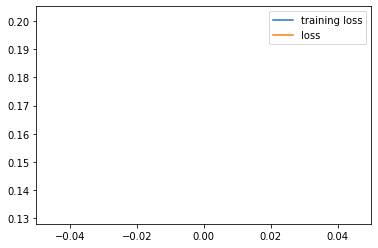

In [0]:
progress[['training loss', 'loss']].plot();

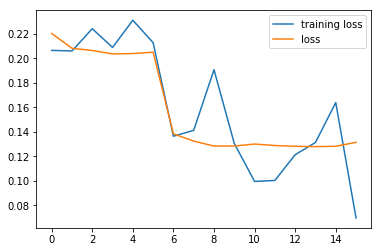

In [0]:
# DO NOT RUN! Original results!
progress[['training loss', 'loss']].plot();

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/core.py:1085: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  ax.set_xlim(left, right)


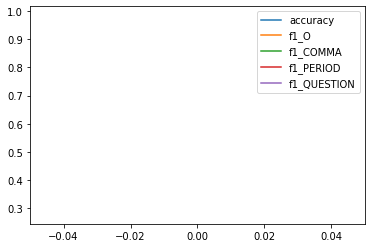

In [0]:
# DO NOT RUN! Original results!
progress[['accuracy', 'f1_O', 'f1_COMMA', 'f1_PERIOD', 'f1_QUESTION']].plot();

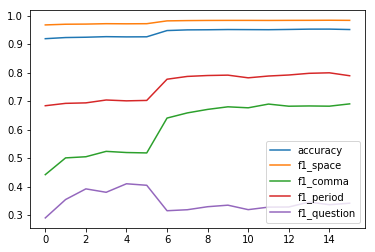

In [0]:
progress[['accuracy', 'f1_space', 'f1_comma', 'f1_period', 'f1_question']].plot();
# progress[['accuracy', 'f1_O', 'f1_PERIOD']].plot();

### Model evaluation

In [0]:
bert_punc.load_state_dict(torch.load(path+'model'))
bert_punc.eval();

In [0]:
batch_size = 1024
data_loader_test = create_data_loader(X_test, y_test, False, batch_size)
data_loader_test_asr = create_data_loader(X_test_asr, y_test_asr, False, batch_size)

In [0]:
def predictions(data_loader):
    y_pred = []
    y_true = []
    for inputs, labels in tqdm(data_loader, total=len(data_loader)):
        with torch.no_grad():
            inputs, labels = inputs.cuda(), labels.cuda()
            output = bert_punc(inputs)
            y_pred += list(output.argmax(dim=1).cpu().data.numpy().flatten())
            y_true += list(labels.cpu().data.numpy().flatten())
    return y_pred, y_true

In [0]:
def evaluation(y_pred, y_test):
    precision, recall, f1, _ = metrics.precision_recall_fscore_support(
        y_test, y_pred, average=None, labels=[1, 2, 3])
    overall = metrics.precision_recall_fscore_support(
        y_test, y_pred, average='macro', labels=[1, 2, 3])
    result = pd.DataFrame(
        np.array([precision, recall, f1]), 
        columns=list(punctuation_enc.keys())[1:], 
        index=['Precision', 'Recall', 'F1']
    )
    result['OVERALL'] = overall[:3]
    return result

In [0]:
# def evaluation(y_pred, y_test):
#     precision, recall, f1, _ = metrics.precision_recall_fscore_support(
#         y_test, y_pred, average=None, labels=[1])
#     overall = metrics.precision_recall_fscore_support(
#         y_test, y_pred, average='macro', labels=[1])
#     result = pd.DataFrame(
#         np.array([precision, recall, f1]), 
#         columns=list(punctuation_enc.keys())[1:], 
#         index=['Precision', 'Recall', 'F1']
#     )
#     result['OVERALL'] = overall[:3]
#     return result

#### Test

In [0]:
data_loader_test

In [0]:
y_pred_test, y_true_test = predictions(data_loader_test)
eval_test = evaluation(y_pred_test, y_true_test)
eval_test

100%|██████████| 14/14 [00:36<00:00,  2.18s/it]


,COMMA,PERIOD,QUESTION,OVERALL
Precision,0.741144,0.809467,0.692308,0.747640
Recall,0.655422,0.847584,0.782609,0.761871
F1,0.695652,0.828087,0.734694,0.752811


In [0]:
# DO NOT RUN! Original results!
y_pred_test, y_true_test = predictions(data_loader_test)
eval_test = evaluation(y_pred_test, y_true_test)
eval_test

100%|██████████| 14/14 [00:12<00:00,  1.57it/s]


,COMMA,PERIOD,QUESTION,OVERALL
Precision,0.670927,0.819083,0.708333,0.732781
Recall,0.759036,0.819083,0.739130,0.772417
F1,0.712267,0.819083,0.723404,0.751585


In [0]:
# https://www.isca-speech.org/archive/Interspeech_2016/pdfs/1517.PDF
ref_test = pd.DataFrame({
    'COMMA':    [0.655, 0.471, 0.548],
    'PERIOD':   [0.733, 0.725, 0.729],
    'QUESTION': [0.707, 0.630, 0.667],
    'OVERALL':  [0.700, 0.597, 0.644]
}, index=['Precision', 'Recall', 'F1'])
ref_test

,COMMA,PERIOD,QUESTION,OVERALL
Precision,0.655,0.733,0.707,0.700
Recall,0.471,0.725,0.630,0.597
F1,0.548,0.729,0.667,0.644


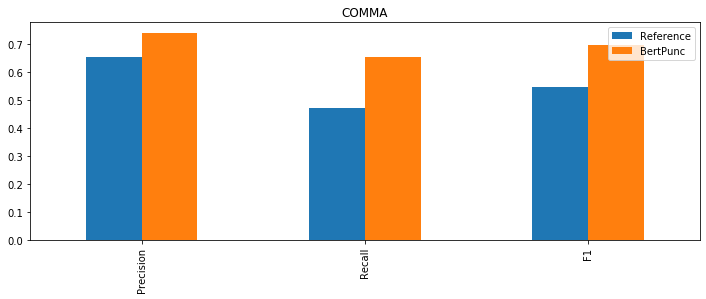

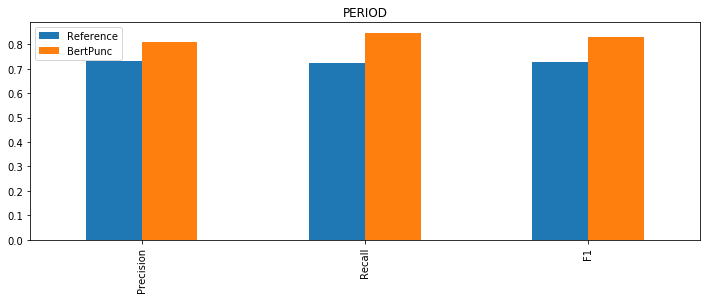

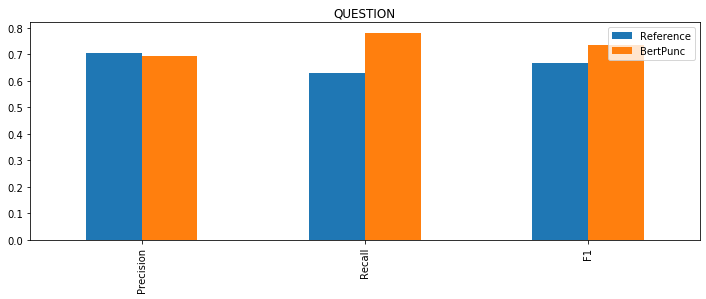

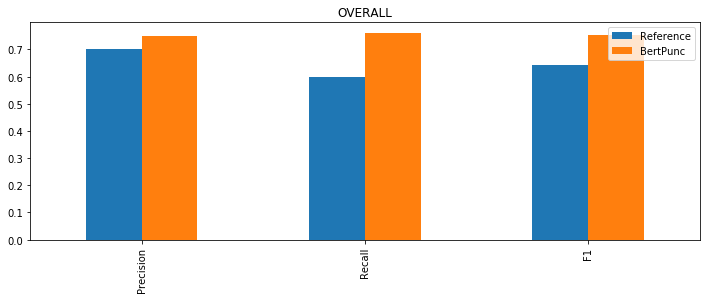

In [0]:
for col in ref_test.columns:
    pd.DataFrame({'Reference': ref_test[col], 'BertPunc': eval_test[col]}).plot.bar(
        title=col, figsize=(12, 4))

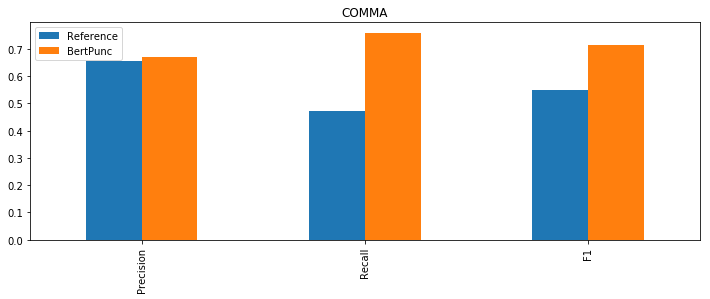

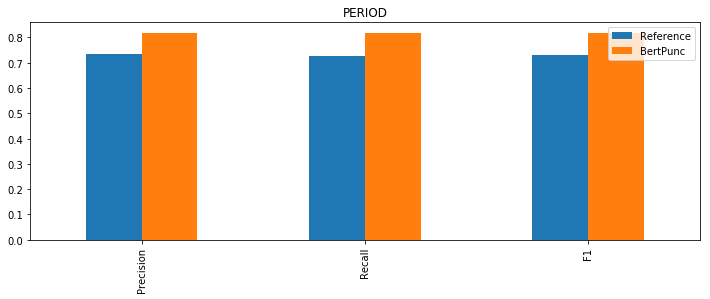

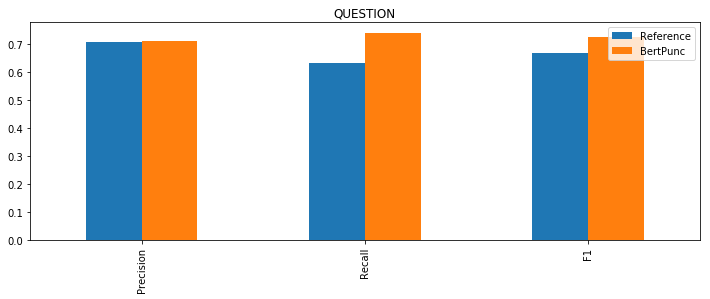

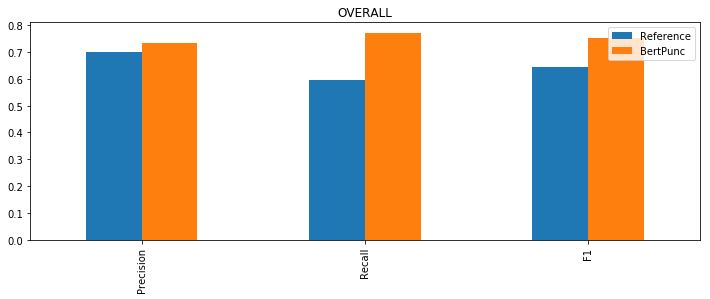

In [0]:
# DO NOT RUN! Original results!
for col in ref_test.columns:
    pd.DataFrame({'Reference': ref_test[col], 'BertPunc': eval_test[col]}).plot.bar(
        title=col, figsize=(12, 4))

#### Test ASR

In [0]:
y_pred_test_asr, y_true_test_asr = predictions(data_loader_test_asr)
eval_test_asr = evaluation(y_pred_test_asr, y_true_test_asr)
eval_test_asr

100%|██████████| 14/14 [00:36<00:00,  2.19s/it]


,COMMA,PERIOD,QUESTION,OVERALL
Precision,0.590286,0.744534,0.444444,0.593088
Recall,0.593985,0.799753,0.571429,0.655055
F1,0.592130,0.771156,0.500000,0.621095


In [0]:
# DO NOT RUN! Original results!
y_pred_test_asr, y_true_test_asr = predictions(data_loader_test_asr)
eval_test_asr = evaluation(y_pred_test_asr, y_true_test_asr)
eval_test_asr

100%|██████████| 14/14 [00:09<00:00,  1.64it/s]


,COMMA,PERIOD,QUESTION,OVERALL
Precision,0.485539,0.771995,0.469388,0.575641
Recall,0.694236,0.770087,0.657143,0.707155
F1,0.571429,0.771040,0.547619,0.630029


In [0]:
# https://www.isca-speech.org/archive/Interspeech_2016/pdfs/1517.PDF
ref_test_asr = pd.DataFrame({
    'COMMA':    [0.596, 0.429, 0.499],
    'PERIOD':   [0.707, 0.720, 0.714],
    'QUESTION': [0.607, 0.486, 0.540],
    'OVERALL':  [0.660, 0.573, 0.614]
}, index=['Precision', 'Recall', 'F1'])
ref_test_asr

,COMMA,PERIOD,QUESTION,OVERALL
Precision,0.596,0.707,0.607,0.660
Recall,0.429,0.720,0.486,0.573
F1,0.499,0.714,0.540,0.614


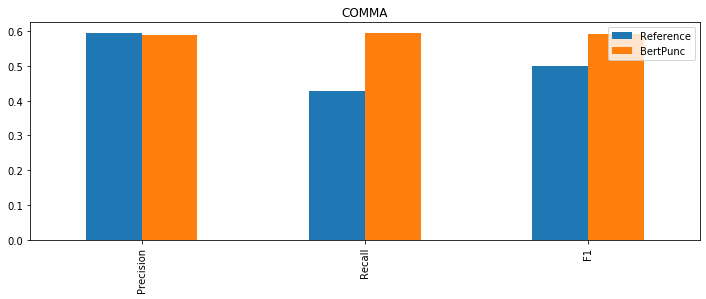

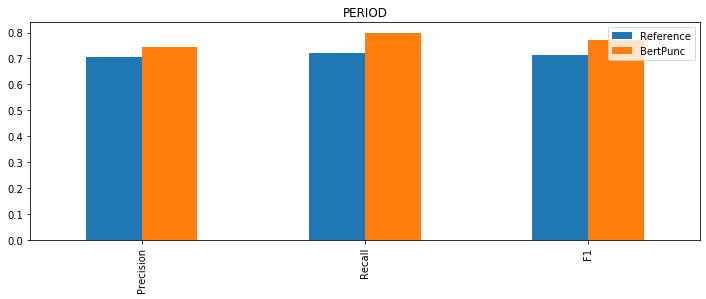

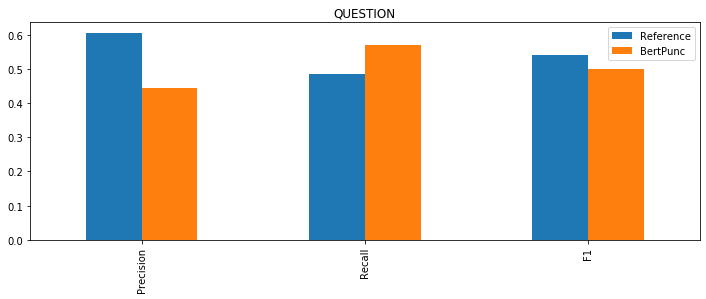

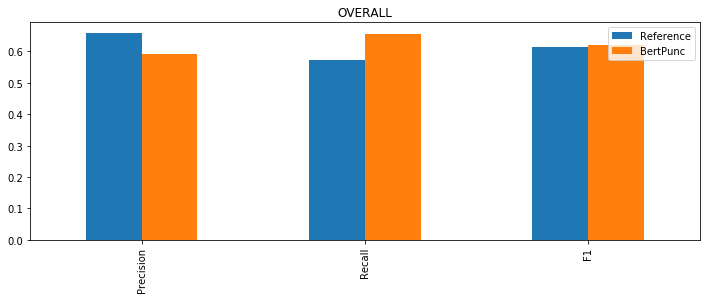

In [0]:
for col in ref_test_asr.columns:
    pd.DataFrame({'Reference': ref_test_asr[col], 'BertPunc': eval_test_asr[col]}).plot.bar(
        title=col, figsize=(12, 4))

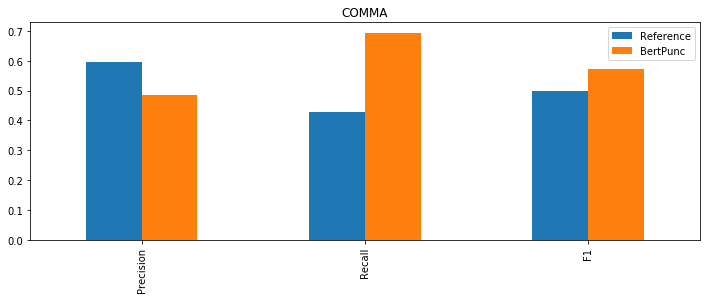

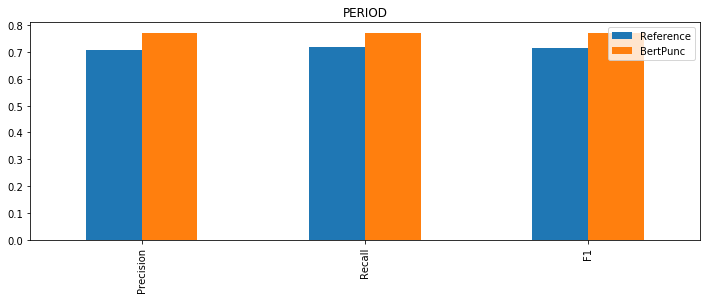

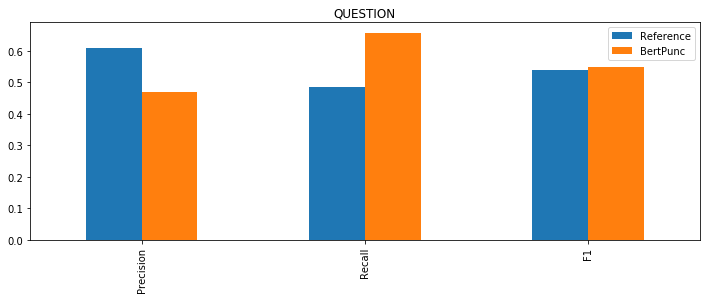

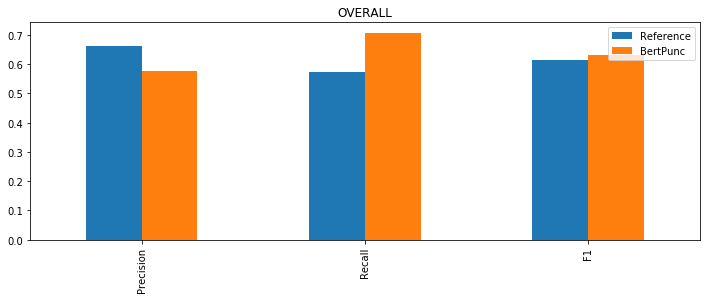

In [0]:
# DO NOT RUN! Original results!
for col in ref_test_asr.columns:
    pd.DataFrame({'Reference': ref_test_asr[col], 'BertPunc': eval_test_asr[col]}).plot.bar(
        title=col, figsize=(12, 4))

# Exploring The Model

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [9]:
%cd drive/My\ Drive/Colab\ Notebooks/Punctuation_Restoration/BertPunc-master_Colab

/content/drive/My Drive/Colab Notebooks/Punctuation_Restoration/BertPunc-master_Colab


In [10]:
!pip install pytorch_pretrained_bert

In [0]:
import pandas as pd
import numpy as np
from glob import glob
from pytorch_pretrained_bert import BertTokenizer
import torch
from torch import nn
%matplotlib inline
import json
from tqdm import tqdm
from sklearn import metrics

from model import BertPunc
from data import load_file, preprocess_data, create_data_loader

In [0]:
from torch.utils.data import TensorDataset, DataLoader

In [13]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

100%|██████████| 231508/231508 [00:00<00:00, 1332354.91B/s]


In [14]:
tokenizer.convert_ids_to_tokens([0])

['[PAD]']

In [0]:
def insert_target(x, segment_size):
 
    X = []
    x_pad = x[-((segment_size-1)//2-1):]+x+x[:segment_size//2]

    for i in range(len(x_pad)-segment_size+2):
        segment = x_pad[i:i+segment_size-1]
        segment.insert((segment_size-1)//2, 0)
        X.append(segment)

    return np.array(X)

In [0]:
l =  [2045, 2003, 2200, 2210, 3983, 2301, 2974, 1999, 2068]

In [93]:
insert_target(l, 8)

array([[1999, 2068, 2045,    0, 2003, 2200, 2210, 3983],
       [2068, 2045, 2003,    0, 2200, 2210, 3983, 2301],
       [2045, 2003, 2200,    0, 2210, 3983, 2301, 2974],
       [2003, 2200, 2210,    0, 3983, 2301, 2974, 1999],
       [2200, 2210, 3983,    0, 2301, 2974, 1999, 2068],
       [2210, 3983, 2301,    0, 2974, 1999, 2068, 2045],
       [3983, 2301, 2974,    0, 1999, 2068, 2045, 2003],
       [2301, 2974, 1999,    0, 2068, 2045, 2003, 2200],
       [2974, 1999, 2068,    0, 2045, 2003, 2200, 2210]])

In [0]:
l =  [2045, 2003, 2200, 2210, 3983, 2301, 2210, 3983, 2301]

In [88]:
insert_target(l, 4)

array([[2045,    0, 2003, 2200],
       [2003,    0, 2200, 2210],
       [2200,    0, 2210, 3983],
       [2210,    0, 3983, 2301],
       [3983,    0, 2301, 2210],
       [2301,    0, 2210, 3983],
       [2210,    0, 3983, 2301],
       [3983,    0, 2301, 2045],
       [2301,    0, 2045, 2003],
       [2045,    0, 2003, 2200],
       [2003,    0, 2200, 2210],
       [2200,    0, 2210, 3983],
       [2210,    0, 3983, 2301],
       [3983,    0, 2301, 2210],
       [2301,    0, 2210, 3983],
       [2210,    0, 3983, 2301],
       [3983,    0, 2301, 2045],
       [2301,    0, 2045, 2003]])

In [0]:
punctuation_enc = {
    'O': 0,
    'COMMA': 1,
    'PERIOD': 2,
    'QUESTION': 3
}

In [0]:
def load_file(filename):
    with open(filename, 'r', encoding="utf8", errors="ignore") as f:  # , encoding='utf-8'
        data = f.readlines()
    return data

In [0]:
def encode_data(data, tokenizer, punctuation_enc):
    X = []
    Y = []
    for line in data:
        word, punc = line.split('\t')
        punc = punc.strip()
        tokens = tokenizer.tokenize(word)
        x = tokenizer.convert_tokens_to_ids(tokens)
        y = [punctuation_enc[punc]]
        if len(x) > 0:
            if len(x) > 1:
                y = (len(x)-1)*[0]+y
            X += x
            Y += y
    return X, Y

In [0]:
def insert_target(x, segment_size):
 
    X = []
    x_pad = x[-((segment_size-1)//2-1):]+x+x[:segment_size//2]

    for i in range(len(x_pad)-segment_size+2):
        segment = x_pad[i:i+segment_size-1]
        segment.insert((segment_size-1)//2, 0)
        X.append(segment)

    return np.array(X)

In [0]:
loaded_data = load_file('train.txt')
X, Y = encode_data(loaded_data, tokenizer, punctuation_enc)
X_pad = insert_target(X, 8)
TD = TensorDataset(torch.from_numpy(X_pad).long(), torch.from_numpy(np.array(Y)).long())
DL = DataLoader(TD, batch_size=6, shuffle=False)

In [58]:
loaded_data[:10]

['i\tO\n',
 'have\tO\n',
 'an\tO\n',
 '18-second\tO\n',
 'clip\tO\n',
 'of\tO\n',
 'the\tO\n',
 'very\tO\n',
 'first\tO\n',
 'walk\tO\n']

In [59]:
X[:10]

[1045, 2031, 2019, 2324, 1011, 2117, 12528, 1997, 1996, 2200]

In [60]:
Y[:10]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [61]:
X_pad[:10]

array([[ 2007,  5505,  1045,     0,  2031,  2019,  2324,  1011],
       [ 5505,  1045,  2031,     0,  2019,  2324,  1011,  2117],
       [ 1045,  2031,  2019,     0,  2324,  1011,  2117, 12528],
       [ 2031,  2019,  2324,     0,  1011,  2117, 12528,  1997],
       [ 2019,  2324,  1011,     0,  2117, 12528,  1997,  1996],
       [ 2324,  1011,  2117,     0, 12528,  1997,  1996,  2200],
       [ 1011,  2117, 12528,     0,  1997,  1996,  2200,  2034],
       [ 2117, 12528,  1997,     0,  1996,  2200,  2034,  3328],
       [12528,  1997,  1996,     0,  2200,  2034,  3328,  1997],
       [ 1997,  1996,  2200,     0,  2034,  3328,  1997,  1996]])

In [62]:
TD

In [63]:
DL

In [15]:
!pip install transformers

     |████████████████████████████████| 491kB 25.6MB/s 
     |████████████████████████████████| 1.0MB 14.8MB/s 
     |████████████████████████████████| 3.8MB 46.7MB/s 
     |████████████████████████████████| 870kB 57.9MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.38-cp36-none-any.whl size=884628 sha256=39e6679d6a0cdf3b9f5d9d2dd96aecb199562da743ff06e0a1111b91751d872e
  Stored in directory: /root/.cache/pip/wheels/6d/ec/1a/21b8912e35e02741306f35f66c785f3afe94de754a0eaf1422
Successfully built sacremoses


In [16]:
from transformers import BertTokenizer, BertForMaskedLM, BertModel

In [41]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
input_ids = torch.tensor(tokenizer.encode("Hello, my dog is cute", add_special_tokens=True)).unsqueeze(0)  # Batch size 1
print(tokenizer.encode("Hello, my dog is cute", add_special_tokens=True))

[101, 7592, 1010, 2026, 3899, 2003, 10140, 102]


In [0]:
# The bare Bert Model transformer outputting raw hidden-states without any specific head on top.
model_BertModel = BertModel.from_pretrained('bert-base-uncased')
outputs_BertModel = model_BertModel(input_ids)

In [0]:
# Bert Model with a language modeling head on top. 
model_BertForMaskedLM = BertForMaskedLM.from_pretrained('bert-base-uncased')
outputs_BertForMaskedLM = model_BertForMaskedLM(input_ids, masked_lm_labels=input_ids)

In [71]:
print(outputs_BertModel[1].size())
print(outputs_BertForMaskedLM[1].size())

torch.Size([1, 768])
torch.Size([1, 8, 30522])


In [0]:
# model_BertModel
# model_BertForMaskedLM

BertForMaskedLM нужна не для маскинга. Вообще, любое название типа BertFor... - Это скорее про дизайн головы модели, нежели про то для чего она нужна.
Так вот, BertForMaskedLM имеет такую голову, которая берет на вход hidden-state'ы, а возвращает распределение по словарю.
Ну а это уже можно использовать для того, чтобы посчитать cross-entropy лосс на замаскированных токенах.
Поэтому, если ты будешь использовать просто BertModel, тебе так или иначе понадобится голова для классификации. И ты просто перепишешь BertForMaskedLM

Сначало я подумал, что этот нулевой-паддинг токен нужен, чтобы обозначить модели место для предполагаемого знака препинания. И он же (хидден стейт этого токена) является входом для финального классификатора. Но потом, я увидел (да и ты написал), что там используется BertForMaskedLM. И соответственно, мы не получаем никаких hidden state'ов, которые пойдут на классификатор. Мы получаем N+1 распределений по словарю (N- это сегмент, и плюс 1 - это паддинг).
И потом, эти N+1 распределений просто фигачатся на классификатор.
В итоге имеем монструозный линейный слой размером segment_size*self.bert_vocab_size
Понятия не имею, почему так сделано. Это странное решение. И кажется, без паддинга тоже будет работать. 

Я думаю, можно сделать просто BertModel + классификатор над hidden state'ами слов.
Такая голова тоже вынесена отдельно и называется BertForTokenClassification. Может я что-то не доглядел, но на первый взгляд решение выглядит реально не оптимальным. 

# Input as text (TRAINED TOP LAYER)

## Timing

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
!dir

7k_without_punctuation.txt	 models
BertPunc_TRAINED_ALL_LAYER.txt	 __pycache__
converter_to_BERT_input.py	 README.md
data				 results
data_for_one_input.py		 row_text.txt
data.py				 test.py
evaluate.ipynb			 train2012_MAX.txt
input_without_second_column.txt  training.ipynb
LICENSE				 train.py
model.py			 train.txt


In [0]:
%cd drive/My\ Drive/Colab\ Notebooks/Punctuation_Restoration/BertPunc-master_GPU

[Errno 2] No such file or directory: 'drive/My Drive/Colab Notebooks/Punctuation_Restoration/BertPunc-master_GPU'
/content/drive/My Drive/Colab Notebooks/Punctuation_Restoration/BertPunc-master_GPU


In [0]:
!dir

7k_without_punctuation.txt	 models
BertPunc_TRAINED_ALL_LAYER.txt	 __pycache__
converter_to_BERT_input.py	 README.md
data				 results
data_for_one_input.py		 row_text.txt
data.py				 test.py
evaluate.ipynb			 train2012_MAX.txt
input_without_second_column.txt  training.ipynb
LICENSE				 train.py
model.py			 train.txt


In [0]:
!pip install pytorch_pretrained_bert

In [2]:
import pandas as pd
import numpy as np
from glob import glob
from pytorch_pretrained_bert import BertTokenizer
import torch
from torch import nn
%matplotlib inline
import json
from tqdm import tqdm
from sklearn import metrics
from model import BertPunc
from data import load_file, preprocess_data, create_data_loader
from torch.utils.data import TensorDataset, DataLoader

ModuleNotFoundError: ignored

In [0]:
# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla P100-PCIE-16GB


In [0]:
batch_size = 1024

In [0]:
glob('results/*')

['results/20200205_012725', 'results/20200206_041031']

In [0]:
path = 'results/20200205_012725/'

In [0]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
with open(path+'hyperparameters.json', 'r') as f:
    hyperparameters = json.load(f)
hyperparameters
punctuation_enc = {
    'O': 0,
    'COMMA': 1,
    'PERIOD': 2,
    'QUESTION': 3
}

segment_size = hyperparameters['segment_size']

In [0]:
def load_file(filename):
    with open(filename, 'r', encoding="utf8", errors="ignore") as f:  # , encoding='utf-8'
        data = f.readlines()
    return data

In [0]:
data_test = load_file('7k_without_punctuation.txt')

In [0]:
X = []
for line in data_test:
    # word = line.split()
    # print(word)
    tokens = tokenizer.tokenize(line)
    x = tokenizer.convert_tokens_to_ids(tokens)
    if len(x) > 0:
        X += x

Token indices sequence length is longer than the specified maximum  sequence length for this BERT model (8112 > 512). Running this sequence through BERT will result in indexing errors


In [0]:
print(' Original: ', data_test)
print('Tokenized: ', tokens)
print('Token IDs: ', X)

 Original:  ["To get here we'd spent a day riding motorbikes over a bumpy mountain pass fording knee-high rivers winding our way up switchbacks and even sidestepping a poisonous snake Now we were close to our destination a black cardamom forest on a nearby peak but couldn't find the approach trail among the shrubs and wildflowers Lang's husband Duong had just wandered off to look for it As it turned out Lang and the hunter were from the same village not far from Hoang Lien National Park He had been farming cardamom in the park for years he said and knew exactly where her family was camped We had entered the park a collection of rugged mountains and valleys near Vietnam's border with China to see cardamom being harvested in the wild Giang Thi Lang and Nguyen Danh Duong are trekking guides in the nearby town of Sa Pa I had befriended them years earlier while living in Hanoi the Vietnamese capital Lang's family has cultivated cardamom in the Hoang Lien Mountains since the 1990s and now he

In [0]:
def insert_target(x, segment_size):

    X = []
    x_pad = x[-((segment_size-1)//2-1):]+x+x[:segment_size//2]

    for i in range(len(x_pad)-segment_size+2):
        segment = x_pad[i:i+segment_size-1]
        segment.insert((segment_size-1)//2, 0)
        X.append(segment)

    return np.array(X)

In [0]:
X_zero_halfway = insert_target(x, segment_size)

In [0]:
type(X_zero_halfway)

numpy.ndarray

In [0]:
data_set = TensorDataset(torch.from_numpy(X_zero_halfway).long())

In [0]:
type(data_set)

torch.utils.data.dataset.TensorDataset

In [0]:
data_loader = DataLoader(data_set, batch_size, shuffle=False)

In [0]:
type(data_loader)

torch.utils.data.dataloader.DataLoader

In [0]:
output_size = len(punctuation_enc)

In [0]:
dropout = hyperparameters['dropout']

In [0]:
bert_punc = nn.DataParallel(BertPunc(segment_size, output_size, dropout).cuda())

In [0]:
bert_punc.load_state_dict(torch.load(path+'model'))

<All keys matched successfully>

In [0]:
bert_punc.eval();

In [0]:
for batch in data_loader:
    # print(batch)
    print(type(batch))
    # print(batch[0])
    print(type(batch[0]))

<class 'list'>
<class 'torch.Tensor'>
<class 'list'>
<class 'torch.Tensor'>
<class 'list'>
<class 'torch.Tensor'>
<class 'list'>
<class 'torch.Tensor'>
<class 'list'>
<class 'torch.Tensor'>
<class 'list'>
<class 'torch.Tensor'>
<class 'list'>
<class 'torch.Tensor'>
<class 'list'>
<class 'torch.Tensor'>


In [0]:
import time
start_time = time.time()
pred = []
for inputs in tqdm(data_loader):
    with torch.no_grad():
        inputs = inputs[0].cuda()
        output = bert_punc(inputs)
        pred += list(output.argmax(dim=1).cpu().data.numpy().flatten())
elapsed_time = time.time() - start_time
print(time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))

100%|██████████| 8/8 [00:09<00:00,  1.21s/it]

00:00:09


In [0]:
pred[:20]

[0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]

In [0]:
pred.count(0)

7139

In [0]:
pred.count(1)

516

In [0]:
pred.count(2)

456

## Quality

In [0]:
import re
restored_text = []
tokens_for_loop = tokens
transformed_pred = [None] * len(tokens_for_loop)
words_with_punctuation = [None] * len(tokens_for_loop) 
restored_text_with_masks = [None] * len(tokens_for_loop)
masking = 0

In [0]:
for i in range(len(tokens_for_loop)):

    # convert to punctuation characters
    if pred[i] == punctuation_enc['COMMA']:
      transformed_pred[i] = ","
    elif pred[i] == punctuation_enc['PERIOD']:
      transformed_pred[i] = "."
    elif pred[i] == punctuation_enc['QUESTION']:
      transformed_pred[i] = "?"
    else:
      transformed_pred[i] = ""
    
    # concatinate words with punctuation characters
    words_with_punctuation[i] = tokens_for_loop[i] + transformed_pred[i]

In [0]:
print('tokens_for_loop', tokens_for_loop)
print('transformed_pred', transformed_pred)
print('words_with_punctuation', words_with_punctuation)

tokens_for_loop ['to', 'get', 'here', 'we', "'", 'd', 'spent', 'a', 'day', 'riding', 'motor', '##bi', '##kes', 'over', 'a', 'bump', '##y', 'mountain', 'pass', 'ford', '##ing', 'knee', '-', 'high', 'rivers', 'winding', 'our', 'way', 'up', 'switch', '##backs', 'and', 'even', 'sides', '##te', '##pping', 'a', 'poisonous', 'snake', 'now', 'we', 'were', 'close', 'to', 'our', 'destination', 'a', 'black', 'card', '##amo', '##m', 'forest', 'on', 'a', 'nearby', 'peak', 'but', 'couldn', "'", 't', 'find', 'the', 'approach', 'trail', 'among', 'the', 'shrubs', 'and', 'wild', '##flower', '##s', 'lang', "'", 's', 'husband', 'duo', '##ng', 'had', 'just', 'wandered', 'off', 'to', 'look', 'for', 'it', 'as', 'it', 'turned', 'out', 'lang', 'and', 'the', 'hunter', 'were', 'from', 'the', 'same', 'village', 'not', 'far', 'from', 'ho', '##ang', 'lie', '##n', 'national', 'park', 'he', 'had', 'been', 'farming', 'card', '##amo', '##m', 'in', 'the', 'park', 'for', 'years', 'he', 'said', 'and', 'knew', 'exactly', '

In [0]:
words_with_punctuation.extend(['#', '#'])
print(words_with_punctuation)

['to', 'get', 'here.', 'we', "'", 'd', 'spent', 'a', 'day', 'riding', 'motor', '##bi', '##kes', 'over', 'a', 'bump', '##y', 'mountain', 'pass,', 'ford', '##ing', 'knee', '-', 'high', 'rivers,', 'winding', 'our', 'way', 'up', 'switch', '##backs,', 'and', 'even', 'sides', '##te', '##pping', 'a', 'poisonous', 'snake.', 'now', 'we', 'were', 'close', 'to', 'our', 'destination', 'a', 'black', 'card', '##amo', '##m', 'forest', 'on', 'a', 'nearby', 'peak,', 'but', 'couldn', "'", 't', 'find', 'the', 'approach', 'trail.', 'among', 'the', 'shrubs', 'and', 'wild', '##flower', '##s.', 'lang', "'", 's', 'husband', 'duo', '##ng', 'had', 'just', 'wandered', 'off', 'to', 'look', 'for', 'it.', 'as', 'it', 'turned', 'out.', 'lang', 'and', 'the', 'hunter', 'were', 'from', 'the', 'same', 'village,', 'not', 'far', 'from', 'ho', '##ang', 'lie', '##n', 'national', 'park.', 'he', 'had', 'been', 'farming', 'card', '##amo', '##m', 'in', 'the', 'park', 'for', 'years.', 'he', 'said,', 'and', 'knew', 'exactly', 'wh

In [0]:
for i in range(len(words_with_punctuation)-2):
  #if i < len(words_with_punctuation)-3:

    # delete masks and concatinate masks words
    if re.findall("#{2}", words_with_punctuation[i+1]):
      restored_text_with_masks[i] = words_with_punctuation[i] + words_with_punctuation[i+1].replace('##', '')
      #del words_with_punctuation[i+1]
      if re.findall("#{2}", words_with_punctuation[i+2]):
        restored_text_with_masks[i] = restored_text_with_masks[i] + words_with_punctuation[i+2].replace('##', '')
        #del words_with_punctuation[i+1]

    else:
      restored_text_with_masks[i] = words_with_punctuation[i]

In [0]:
print(restored_text_with_masks)
print(len(restored_text_with_masks))
print(len(tokens_for_loop))
restored_text_with_masks_for_loop = restored_text_with_masks

['to', 'get', 'here.', 'we', "'", 'd', 'spent', 'a', 'day', 'riding', 'motorbikes', '##bikes', '##kes', 'over', 'a', 'bumpy', '##y', 'mountain', 'pass,', 'fording', '##ing', 'knee', '-', 'high', 'rivers,', 'winding', 'our', 'way', 'up', 'switchbacks,', '##backs,', 'and', 'even', 'sidestepping', '##tepping', '##pping', 'a', 'poisonous', 'snake.', 'now', 'we', 'were', 'close', 'to', 'our', 'destination', 'a', 'black', 'cardamom', '##amom', '##m', 'forest', 'on', 'a', 'nearby', 'peak,', 'but', 'couldn', "'", 't', 'find', 'the', 'approach', 'trail.', 'among', 'the', 'shrubs', 'and', 'wildflowers.', '##flowers.', '##s.', 'lang', "'", 's', 'husband', 'duong', '##ng', 'had', 'just', 'wandered', 'off', 'to', 'look', 'for', 'it.', 'as', 'it', 'turned', 'out.', 'lang', 'and', 'the', 'hunter', 'were', 'from', 'the', 'same', 'village,', 'not', 'far', 'from', 'hoang', '##ang', 'lien', '##n', 'national', 'park.', 'he', 'had', 'been', 'farming', 'cardamom', '##amom', '##m', 'in', 'the', 'park', 'for'

In [0]:
# for i in range(len(restored_text_with_masks_for_loop)):
#   if re.findall("#", restored_text_with_masks_for_loop[i]):
#     del restored_text_with_masks_for_loop[i]

restored_text_without_masks = []
for i in range(len(restored_text_with_masks_for_loop)):
  if re.findall("#", restored_text_with_masks_for_loop[i]) != ['#', '#']:
    restored_text_without_masks.append(restored_text_with_masks_for_loop[i])

In [0]:
print(restored_text_without_masks)

['to', 'get', 'here.', 'we', "'", 'd', 'spent', 'a', 'day', 'riding', 'motorbikes', 'over', 'a', 'bumpy', 'mountain', 'pass,', 'fording', 'knee', '-', 'high', 'rivers,', 'winding', 'our', 'way', 'up', 'switchbacks,', 'and', 'even', 'sidestepping', 'a', 'poisonous', 'snake.', 'now', 'we', 'were', 'close', 'to', 'our', 'destination', 'a', 'black', 'cardamom', 'forest', 'on', 'a', 'nearby', 'peak,', 'but', 'couldn', "'", 't', 'find', 'the', 'approach', 'trail.', 'among', 'the', 'shrubs', 'and', 'wildflowers.', 'lang', "'", 's', 'husband', 'duong', 'had', 'just', 'wandered', 'off', 'to', 'look', 'for', 'it.', 'as', 'it', 'turned', 'out.', 'lang', 'and', 'the', 'hunter', 'were', 'from', 'the', 'same', 'village,', 'not', 'far', 'from', 'hoang', 'lien', 'national', 'park.', 'he', 'had', 'been', 'farming', 'cardamom', 'in', 'the', 'park', 'for', 'years.', 'he', 'said,', 'and', 'knew', 'exactly', 'where', 'her', 'family', 'was', 'camped.', 'we', 'had', 'entered', 'the', 'park,', 'a', 'collectio

In [0]:
text_not_capitalize = " ".join(restored_text_without_masks).replace(" ' ", "'").replace(" - ", "-")

In [0]:
print(text_not_capitalize)

to get here. we'd spent a day riding motorbikes over a bumpy mountain pass, fording knee-high rivers, winding our way up switchbacks, and even sidestepping a poisonous snake. now we were close to our destination a black cardamom forest on a nearby peak, but couldn't find the approach trail. among the shrubs and wildflowers. lang's husband duong had just wandered off to look for it. as it turned out. lang and the hunter were from the same village, not far from hoang lien national park. he had been farming cardamom in the park for years. he said, and knew exactly where her family was camped. we had entered the park, a collection of rugged mountains and valleys near vietnam's border with china to see cardamom being harvested in the wild. giang, thi lang and nguyen danh duong are trekking guides in the nearby town of sa pa. i had befriended them years earlier, while living in hanoi, the vietnamese capital, lang's family has cultivated cardamom in the hoang lien mountains since the 1990s. a

In [0]:
from nltk.tokenize import sent_tokenize
nltk.download('punkt')
#sent_tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')
sentences = sent_tokenize(text_not_capitalize)
sentences = [sent.capitalize() for sent in sentences]
text = ' '.join(sentences)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [0]:
print(text)

To get here. We'd spent a day riding motorbikes over a bumpy mountain pass, fording knee-high rivers, winding our way up switchbacks, and even sidestepping a poisonous snake. Now we were close to our destination a black cardamom forest on a nearby peak, but couldn't find the approach trail. Among the shrubs and wildflowers. Lang's husband duong had just wandered off to look for it. As it turned out. Lang and the hunter were from the same village, not far from hoang lien national park. He had been farming cardamom in the park for years. He said, and knew exactly where her family was camped. We had entered the park, a collection of rugged mountains and valleys near vietnam's border with china to see cardamom being harvested in the wild. Giang, thi lang and nguyen danh duong are trekking guides in the nearby town of sa pa. i had befriended them years earlier, while living in hanoi, the vietnamese capital, lang's family has cultivated cardamom in the hoang lien mountains since the 1990s. A

In [0]:
with open("BertPunc_TRAINED_TOP_LAYER.txt", "w") as text_file:
    text_file.write(text)

# Input as text (TRAINED ALL LAYER)

## Timing

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
!dir

7k_without_punctuation.txt	 LICENSE       test.py
converter_to_BERT_input.py	 model.py      text_example.txt
data				 models        train2012_MAX.txt
data_for_one_input.py		 __pycache__   training.ipynb
data.py				 README.md     train.py
evaluate.ipynb			 results       train.txt
input_without_second_column.txt  row_text.txt


In [0]:
%cd drive/My\ Drive/Colab\ Notebooks/Punctuation_Restoration/BertPunc-master_GPU

[Errno 2] No such file or directory: 'drive/My Drive/Colab Notebooks/Punctuation_Restoration/BertPunc-master_GPU'
/content/drive/My Drive/Colab Notebooks/Punctuation_Restoration/BertPunc-master_GPU


In [0]:
!dir

7k_without_punctuation.txt	 LICENSE       test.py
converter_to_BERT_input.py	 model.py      text_example.txt
data				 models        train2012_MAX.txt
data_for_one_input.py		 __pycache__   training.ipynb
data.py				 README.md     train.py
evaluate.ipynb			 results       train.txt
input_without_second_column.txt  row_text.txt


In [0]:
!pip install pytorch_pretrained_bert

In [0]:
import pandas as pd
import numpy as np
from glob import glob
from pytorch_pretrained_bert import BertTokenizer
import torch
from torch import nn
%matplotlib inline
import json
from tqdm import tqdm
from sklearn import metrics
from model import BertPunc
from data import load_file, preprocess_data, create_data_loader
from torch.utils.data import TensorDataset, DataLoader

In [0]:
# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla P100-PCIE-16GB


In [0]:
batch_size = 1024

In [0]:
glob('results/*')

['results/20200205_012725', 'results/20200206_041031']

In [0]:
path = 'results/20200206_041031/'

In [0]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
with open(path+'hyperparameters.json', 'r') as f:
    hyperparameters = json.load(f)
hyperparameters
punctuation_enc = {
    'O': 0,
    'COMMA': 1,
    'PERIOD': 2,
    'QUESTION': 3
}

segment_size = hyperparameters['segment_size']

In [0]:
def load_file(filename):
    with open(filename, 'r', encoding="utf8", errors="ignore") as f:  # , encoding='utf-8'
        data = f.readlines()
    return data

In [0]:
data_test = load_file('7k_without_punctuation.txt')

In [0]:
X = []
for line in data_test:
    # word = line.split()
    # print(word)
    tokens = tokenizer.tokenize(line)
    x = tokenizer.convert_tokens_to_ids(tokens)
    if len(x) > 0:
        X += x

Token indices sequence length is longer than the specified maximum  sequence length for this BERT model (8112 > 512). Running this sequence through BERT will result in indexing errors


In [0]:
print(' Original: ', data_test)
print('Tokenized: ', tokens)
print('Token IDs: ', X)

 Original:  ["To get here we'd spent a day riding motorbikes over a bumpy mountain pass fording knee-high rivers winding our way up switchbacks and even sidestepping a poisonous snake Now we were close to our destination a black cardamom forest on a nearby peak but couldn't find the approach trail among the shrubs and wildflowers Lang's husband Duong had just wandered off to look for it As it turned out Lang and the hunter were from the same village not far from Hoang Lien National Park He had been farming cardamom in the park for years he said and knew exactly where her family was camped We had entered the park a collection of rugged mountains and valleys near Vietnam's border with China to see cardamom being harvested in the wild Giang Thi Lang and Nguyen Danh Duong are trekking guides in the nearby town of Sa Pa I had befriended them years earlier while living in Hanoi the Vietnamese capital Lang's family has cultivated cardamom in the Hoang Lien Mountains since the 1990s and now he

In [0]:
def insert_target(x, segment_size):

    X = []
    x_pad = x[-((segment_size-1)//2-1):]+x+x[:segment_size//2]

    for i in range(len(x_pad)-segment_size+2):
        segment = x_pad[i:i+segment_size-1]
        segment.insert((segment_size-1)//2, 0)
        X.append(segment)

    return np.array(X)

In [0]:
X_zero_halfway = insert_target(x, segment_size)

In [0]:
type(X_zero_halfway)

numpy.ndarray

In [0]:
data_set = TensorDataset(torch.from_numpy(X_zero_halfway).long())

In [0]:
type(data_set)

torch.utils.data.dataset.TensorDataset

In [0]:
data_loader = DataLoader(data_set, batch_size, shuffle=False)

In [0]:
type(data_loader)

torch.utils.data.dataloader.DataLoader

In [0]:
output_size = len(punctuation_enc)

In [0]:
dropout = hyperparameters['dropout']

In [0]:
bert_punc = nn.DataParallel(BertPunc(segment_size, output_size, dropout).cuda())

In [0]:
bert_punc.load_state_dict(torch.load(path+'model'))

<All keys matched successfully>

In [0]:
bert_punc.eval();

In [0]:
for batch in data_loader:
    # print(batch)
    print(type(batch))
    # print(batch[0])
    print(type(batch[0]))

<class 'list'>
<class 'torch.Tensor'>
<class 'list'>
<class 'torch.Tensor'>
<class 'list'>
<class 'torch.Tensor'>
<class 'list'>
<class 'torch.Tensor'>
<class 'list'>
<class 'torch.Tensor'>
<class 'list'>
<class 'torch.Tensor'>
<class 'list'>
<class 'torch.Tensor'>
<class 'list'>
<class 'torch.Tensor'>


In [0]:
import time
start_time = time.time()
pred = []
for inputs in tqdm(data_loader):
    with torch.no_grad():
        inputs = inputs[0].cuda()
        output = bert_punc(inputs)
        pred += list(output.argmax(dim=1).cpu().data.numpy().flatten())
elapsed_time = time.time() - start_time
print(time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))

100%|██████████| 8/8 [00:09<00:00,  1.21s/it]

00:00:09


In [0]:
pred[:20]

[0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]

In [0]:
pred.count(0)

7273

In [0]:
pred.count(1)

420

In [0]:
pred.count(2)

416

In [0]:
len(tokens)

8112

In [0]:
len(pred)

8112

## Quality

In [0]:
import re
restored_text = []
tokens_for_loop = tokens
transformed_pred = [None] * len(tokens_for_loop)
words_with_punctuation = [None] * len(tokens_for_loop) 
restored_text_with_masks = [None] * len(tokens_for_loop)
masking = 0

In [0]:
for i in range(len(tokens_for_loop)):

    # convert to punctuation characters
    if pred[i] == punctuation_enc['COMMA']:
      transformed_pred[i] = ","
    elif pred[i] == punctuation_enc['PERIOD']:
      transformed_pred[i] = "."
    elif pred[i] == punctuation_enc['QUESTION']:
      transformed_pred[i] = "?"
    else:
      transformed_pred[i] = ""
    
    # concatinate words with punctuation characters
    words_with_punctuation[i] = tokens_for_loop[i] + transformed_pred[i]

In [0]:
print('tokens_for_loop', tokens_for_loop)
print('transformed_pred', transformed_pred)
print('words_with_punctuation', words_with_punctuation)

tokens_for_loop ['to', 'get', 'here', 'we', "'", 'd', 'spent', 'a', 'day', 'riding', 'motor', '##bi', '##kes', 'over', 'a', 'bump', '##y', 'mountain', 'pass', 'ford', '##ing', 'knee', '-', 'high', 'rivers', 'winding', 'our', 'way', 'up', 'switch', '##backs', 'and', 'even', 'sides', '##te', '##pping', 'a', 'poisonous', 'snake', 'now', 'we', 'were', 'close', 'to', 'our', 'destination', 'a', 'black', 'card', '##amo', '##m', 'forest', 'on', 'a', 'nearby', 'peak', 'but', 'couldn', "'", 't', 'find', 'the', 'approach', 'trail', 'among', 'the', 'shrubs', 'and', 'wild', '##flower', '##s', 'lang', "'", 's', 'husband', 'duo', '##ng', 'had', 'just', 'wandered', 'off', 'to', 'look', 'for', 'it', 'as', 'it', 'turned', 'out', 'lang', 'and', 'the', 'hunter', 'were', 'from', 'the', 'same', 'village', 'not', 'far', 'from', 'ho', '##ang', 'lie', '##n', 'national', 'park', 'he', 'had', 'been', 'farming', 'card', '##amo', '##m', 'in', 'the', 'park', 'for', 'years', 'he', 'said', 'and', 'knew', 'exactly', '

In [0]:
words_with_punctuation.extend(['#', '#'])
print(words_with_punctuation)

['to', 'get', 'here.', 'we', "'", 'd', 'spent', 'a', 'day', 'riding', 'motor', '##bi', '##kes', 'over', 'a', 'bump', '##y', 'mountain', 'pass,', 'ford', '##ing', 'knee', '-', 'high', 'rivers,', 'winding', 'our', 'way', 'up', 'switch', '##backs', 'and', 'even', 'sides', '##te', '##pping', 'a', 'poisonous', 'snake.', 'now', 'we', 'were', 'close', 'to', 'our', 'destination,', 'a', 'black', 'card', '##amo', '##m', 'forest', 'on', 'a', 'nearby', 'peak,', 'but', 'couldn', "'", 't', 'find', 'the', 'approach', 'trail', 'among', 'the', 'shrubs', 'and', 'wild', '##flower', '##s.', 'lang', "'", 's', 'husband', 'duo', '##ng', 'had', 'just', 'wandered', 'off', 'to', 'look', 'for', 'it.', 'as', 'it', 'turned', 'out,', 'lang', 'and', 'the', 'hunter', 'were', 'from', 'the', 'same', 'village', 'not', 'far', 'from', 'ho', '##ang', 'lie', '##n', 'national', 'park.', 'he', 'had', 'been', 'farming', 'card', '##amo', '##m', 'in', 'the', 'park', 'for', 'years,', 'he', 'said,', 'and', 'knew', 'exactly', 'wher

In [0]:
for i in range(len(words_with_punctuation)-2):
  #if i < len(words_with_punctuation)-3:

    # delete masks and concatinate masks words
    if re.findall("#{2}", words_with_punctuation[i+1]):
      restored_text_with_masks[i] = words_with_punctuation[i] + words_with_punctuation[i+1].replace('##', '')
      #del words_with_punctuation[i+1]
      if re.findall("#{2}", words_with_punctuation[i+2]):
        restored_text_with_masks[i] = restored_text_with_masks[i] + words_with_punctuation[i+2].replace('##', '')
        #del words_with_punctuation[i+1]

    else:
      restored_text_with_masks[i] = words_with_punctuation[i]

In [0]:
print(restored_text_with_masks)
print(len(restored_text_with_masks))
print(len(tokens_for_loop))
restored_text_with_masks_for_loop = restored_text_with_masks

['to', 'get', 'here.', 'we', "'", 'd', 'spent', 'a', 'day', 'riding', 'motorbikes', '##bikes', '##kes', 'over', 'a', 'bumpy', '##y', 'mountain', 'pass,', 'fording', '##ing', 'knee', '-', 'high', 'rivers,', 'winding', 'our', 'way', 'up', 'switchbacks', '##backs', 'and', 'even', 'sidestepping', '##tepping', '##pping', 'a', 'poisonous', 'snake.', 'now', 'we', 'were', 'close', 'to', 'our', 'destination,', 'a', 'black', 'cardamom', '##amom', '##m', 'forest', 'on', 'a', 'nearby', 'peak,', 'but', 'couldn', "'", 't', 'find', 'the', 'approach', 'trail', 'among', 'the', 'shrubs', 'and', 'wildflowers.', '##flowers.', '##s.', 'lang', "'", 's', 'husband', 'duong', '##ng', 'had', 'just', 'wandered', 'off', 'to', 'look', 'for', 'it.', 'as', 'it', 'turned', 'out,', 'lang', 'and', 'the', 'hunter', 'were', 'from', 'the', 'same', 'village', 'not', 'far', 'from', 'hoang', '##ang', 'lien', '##n', 'national', 'park.', 'he', 'had', 'been', 'farming', 'cardamom', '##amom', '##m', 'in', 'the', 'park', 'for', '

In [0]:
# for i in range(len(restored_text_with_masks_for_loop)):
#   if re.findall("#", restored_text_with_masks_for_loop[i]):
#     del restored_text_with_masks_for_loop[i]

restored_text_without_masks = []
for i in range(len(restored_text_with_masks_for_loop)):
  if re.findall("#", restored_text_with_masks_for_loop[i]) != ['#', '#']:
    restored_text_without_masks.append(restored_text_with_masks_for_loop[i])

In [0]:
print(restored_text_without_masks)

['to', 'get', 'here.', 'we', "'", 'd', 'spent', 'a', 'day', 'riding', 'motorbikes', 'over', 'a', 'bumpy', 'mountain', 'pass,', 'fording', 'knee', '-', 'high', 'rivers,', 'winding', 'our', 'way', 'up', 'switchbacks', 'and', 'even', 'sidestepping', 'a', 'poisonous', 'snake.', 'now', 'we', 'were', 'close', 'to', 'our', 'destination,', 'a', 'black', 'cardamom', 'forest', 'on', 'a', 'nearby', 'peak,', 'but', 'couldn', "'", 't', 'find', 'the', 'approach', 'trail', 'among', 'the', 'shrubs', 'and', 'wildflowers.', 'lang', "'", 's', 'husband', 'duong', 'had', 'just', 'wandered', 'off', 'to', 'look', 'for', 'it.', 'as', 'it', 'turned', 'out,', 'lang', 'and', 'the', 'hunter', 'were', 'from', 'the', 'same', 'village', 'not', 'far', 'from', 'hoang', 'lien', 'national', 'park.', 'he', 'had', 'been', 'farming', 'cardamom', 'in', 'the', 'park', 'for', 'years,', 'he', 'said,', 'and', 'knew', 'exactly', 'where', 'her', 'family', 'was', 'camped.', 'we', 'had', 'entered', 'the', 'park,', 'a', 'collection'

In [0]:
text_not_capitalize = " ".join(restored_text_without_masks).replace(" ' ", "'").replace(" - ", "-")

In [0]:
print(text_not_capitalize)

to get here. we'd spent a day riding motorbikes over a bumpy mountain pass, fording knee-high rivers, winding our way up switchbacks and even sidestepping a poisonous snake. now we were close to our destination, a black cardamom forest on a nearby peak, but couldn't find the approach trail among the shrubs and wildflowers. lang's husband duong had just wandered off to look for it. as it turned out, lang and the hunter were from the same village not far from hoang lien national park. he had been farming cardamom in the park for years, he said, and knew exactly where her family was camped. we had entered the park, a collection of rugged mountains and valleys near vietnam's border with china, to see cardamom being harvested in the wild. giang thi lang and nguyen danh duong are trekking guides in the nearby town of sa pa. i had befriended them years earlier while living in hanoi, the vietnamese capital. lang's family has cultivated cardamom in the hoang lien mountains since the 1990s. and 

In [0]:
from nltk.tokenize import sent_tokenize
nltk.download('punkt')
#sent_tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')
sentences = sent_tokenize(text_not_capitalize)
sentences = [sent.capitalize() for sent in sentences]
text = ' '.join(sentences)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [0]:
print(text)

To get here. We'd spent a day riding motorbikes over a bumpy mountain pass, fording knee-high rivers, winding our way up switchbacks and even sidestepping a poisonous snake. Now we were close to our destination, a black cardamom forest on a nearby peak, but couldn't find the approach trail among the shrubs and wildflowers. Lang's husband duong had just wandered off to look for it. As it turned out, lang and the hunter were from the same village not far from hoang lien national park. He had been farming cardamom in the park for years, he said, and knew exactly where her family was camped. We had entered the park, a collection of rugged mountains and valleys near vietnam's border with china, to see cardamom being harvested in the wild. Giang thi lang and nguyen danh duong are trekking guides in the nearby town of sa pa. i had befriended them years earlier while living in hanoi, the vietnamese capital. Lang's family has cultivated cardamom in the hoang lien mountains since the 1990s. And 

In [0]:
with open("BertPunc_TRAINED_ALL_LAYER.txt", "w") as text_file:
    text_file.write(text)